In [2]:
#@title 1.3. IMPORT LIBRARY

import sys
sys.path.append('../utils')
from credit_base import *
from neural_net import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [177]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
X.columns = ['Checking account', 'Duration', 'Credit history', 'Purpose',
            'Credit amount', 'Savings account', 'Employment since', 'Installment rate',
            'Marital status', 'Other debtors/guarantors', 'Residence since',
            'Property', 'Age', 'Other installments', 'Housing', 'Existing credits',
            'Job', 'Maintenance people', 'Telephone', 'Foreign worker']

# X['Age category'] = X['Age'].apply(age_categorize)
# X.drop(columns=['Existing credits'], inplace=True)

# # Monthly pay
X['Monthly pay'] = (X["Credit amount"] / X["Duration"])

# X['Maturity'] = X['Age'] + X['Duration'] / 12
# X['Purpose'] = X['Purpose'].apply(purpose_categorize)

# # Credit amount
# X["Credit amount"] = np.log(X["Credit amount"])

# # Duration
# X['Duration'] = np.log(X['Duration'])

X = pd.get_dummies(X, dtype='int')

# qt = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0)
# X = pd.DataFrame(qt.fit_transform(X), columns=X.columns)

scaler = RobustScaler(quantile_range=(10, 90))
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y['class'] = y['class'].map({1: 1, 2: 0})
y.columns = ['Risk']


X.head()

/tmp/ipykernel_1666/767244981.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class'] = y['class'].map({1: 1, 2: 0})


,Duration,Credit amount,Installment rate,Residence since,Age,Existing credits,Maintenance people,Monthly pay,Checking account_A11,Checking account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,Foreign worker_A201,Foreign worker_A202
0,-0.444444,-0.184157,0.333333,0.333333,1.172414,1.0,0.0,0.273199,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
1,1.111111,0.581282,-0.333333,-0.333333,-0.379310,0.0,0.0,-0.026914,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.222222,-0.035775,-0.333333,0.000000,0.551724,0.0,1.0,0.187780,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,0.888889,0.890370,-0.333333,0.333333,0.413793,0.0,1.0,0.242844,1.0,0.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.222222,0.408250,0.000000,0.333333,0.689655,1.0,1.0,0.307437,1.0,0.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
df = pd.concat([X, y], axis=1)
df.head()

,Duration,Credit amount,Installment rate,Residence since,Age,Existing credits,Maintenance people,Monthly pay,Checking account_A11,Checking account_A12,...,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,Foreign worker_A201,Foreign worker_A202,Risk
0,-0.444444,-0.184157,0.333333,0.333333,1.172414,1.0,0.0,0.273199,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,1
1,1.111111,0.581282,-0.333333,-0.333333,-0.379310,0.0,0.0,-0.026914,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.222222,-0.035775,-0.333333,0.000000,0.551724,0.0,1.0,0.187780,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1
3,0.888889,0.890370,-0.333333,0.333333,0.413793,0.0,1.0,0.242844,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.222222,0.408250,0.000000,0.333333,0.689655,1.0,1.0,0.307437,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [179]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        probs_class_1 = probs[:, 1]  # Focus on class 1
        targets = targets.double()
        bce_loss = nn.BCELoss(reduction='none')(probs_class_1, targets)
        pt = torch.where(targets == 1, probs_class_1, 1 - probs_class_1)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=0.25, gamma=2)


In [190]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n = df.shape[1] - 1

train_accuracies = []
test_accuracies = []

# Perform 5-fold stratified cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(df, df['Risk'])):
    print(f"Fold {fold+1}/{5}")
    
    # Split the data for this fold
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
    X_train, y_train = df_train.drop(columns='Risk'), df_train['Risk']
    X_test, y_test = df_test.drop(columns='Risk'), df_test['Risk']
    
    # Prepare the dataset
    dataset = dict()
    dtype = torch.get_default_dtype()
    dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train.values).type(torch.long).to(device)
    dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
    dataset['test_label'] = torch.from_numpy(y_test.values).type(torch.long).to(device)

    # Initialize model
    model = KAN(width=[n, 6, 2], grid=4, k=2, seed=42, symbolic_enabled=True, device=device)

    # Train the model and evaluate it
    results = model.fit(dataset, opt="Adam", steps=150, lr=0.001, lamb=0.001, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

    print(f'Fold accuracy: {results['train_acc'][-1], results['test_acc'][-1]}')
    
    train_accuracies.append(results['train_acc'][-1])
    test_accuracies.append(results['test_acc'][-1])

# Output the average accuracies
print(f"Average Train Accuracy: {torch.mean(torch.tensor(train_accuracies)):.4f}")
print(f"Average Test Accuracy: {torch.mean(torch.tensor(test_accuracies)):.4f}")

Fold 1/5
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 6.65e-01 | test_loss: 7.05e-01 | reg: 3.25e+01 | : 100%|█| 150/150 [00:09<00:00, 16.45


saving model version 0.1
Fold accuracy: (0.80125, 0.75)
Fold 2/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.63e-01 | test_loss: 7.17e-01 | reg: 3.27e+01 | : 100%|█| 150/150 [00:08<00:00, 16.86


saving model version 0.1
Fold accuracy: (0.8075, 0.775)
Fold 3/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.69e-01 | test_loss: 7.05e-01 | reg: 3.10e+01 | : 100%|█| 150/150 [00:08<00:00, 16.90


saving model version 0.1
Fold accuracy: (0.80375, 0.755)
Fold 4/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.73e-01 | test_loss: 6.87e-01 | reg: 3.21e+01 | : 100%|█| 150/150 [00:08<00:00, 16.80


saving model version 0.1
Fold accuracy: (0.79, 0.775)
Fold 5/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.68e-01 | test_loss: 6.99e-01 | reg: 3.23e+01 | : 100%|█| 150/150 [00:09<00:00, 16.65


saving model version 0.1
Fold accuracy: (0.80125, 0.795)
Average Train Accuracy: 0.8008
Average Test Accuracy: 0.7700


In [ ]:
help(model.fit)

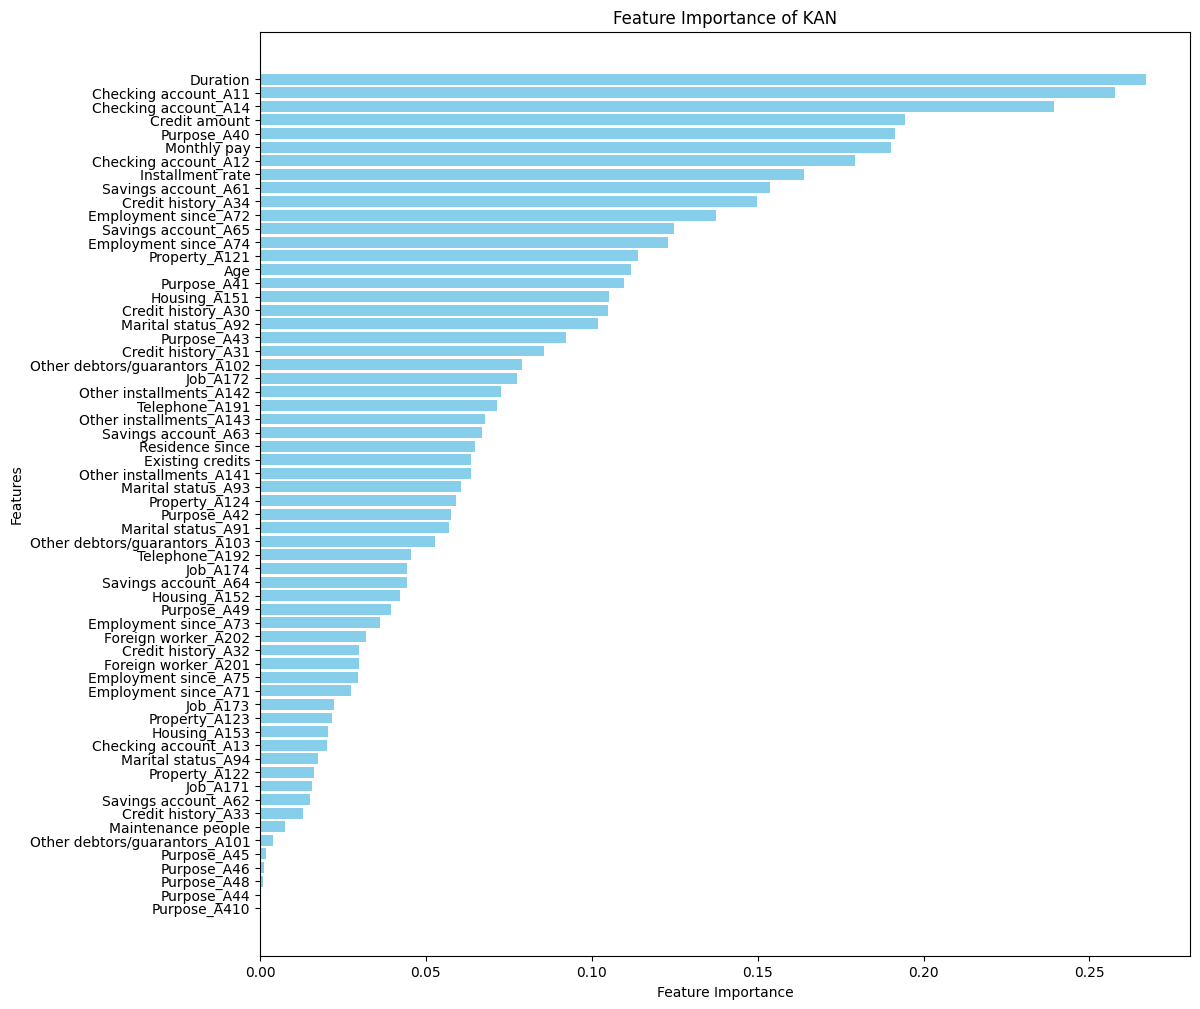

In [185]:
columns = list(X.columns)
importance_values = model.feature_score.cpu().detach().numpy()

sorted_indices = np.argsort(importance_values)[::1]
sorted_importance_values = importance_values[sorted_indices]
sorted_columns = np.array(columns)[sorted_indices]


# Bar plot oluşturma
plt.figure(figsize=(12, 12))
plt.barh(sorted_columns, sorted_importance_values, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of KAN')
plt.show()

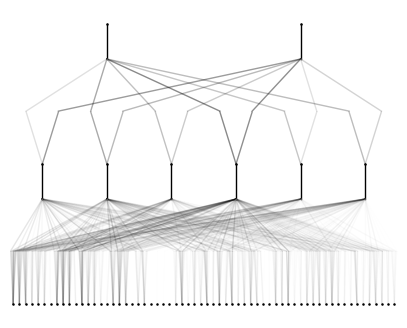

In [86]:
model.plot()

In [ ]:
layer_1 = model.acts_scale[0].detach().numpy()
layer_2 = model.acts_scale[1].detach().numpy()

columns = list(X.columns)
importance_values = np.dot(layer_1.T, layer_2.T)

sorted_indices = np.argsort(importance_values[:, 0])[::1]
sorted_importance_values = importance_values[:, 0][sorted_indices]
sorted_columns = np.array(columns)[sorted_indices]

plt.figure(figsize=(12, 12))
plt.barh(sorted_columns, sorted_importance_values, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of KAN')
plt.show()

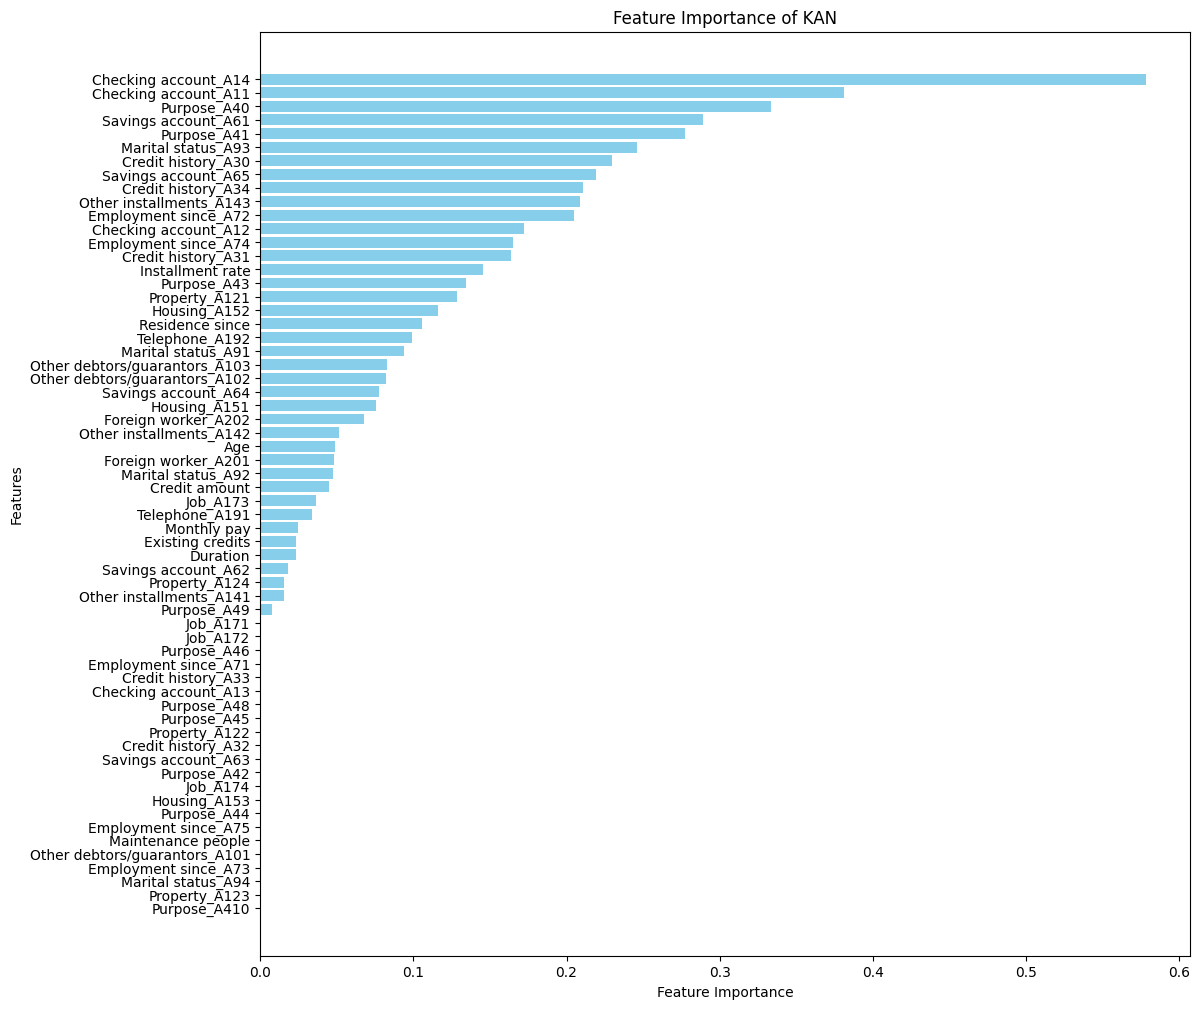

In [ ]:
sorted_indices = np.argsort(importance_values[:, 1])[::1]
sorted_importance_values = importance_values[:, 1][sorted_indices]
sorted_columns = np.array(columns)[sorted_indices]

plt.figure(figsize=(12, 12))
plt.barh(sorted_columns, sorted_importance_values, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of KAN')
plt.show()